In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
import seaborn as sns
from tensorflow import keras
# tf.config.run_functions_eagerly(True)
print("TensorFlow version:", tf.__version__)


from shutil import copy
from PIL import Image

# sys.path.insert(1, '../../utils')

TensorFlow version: 2.9.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    with open(filepath, 'r') as txt:
        paths = [read.strip()+'/rgb.png' for read in txt.readlines()]

    if not os.path.exists(dest):
        os.makedirs(dest)

    for food in paths:
        out = food.split('/')
        dest_name = out[0]+'.png'
        src_path = os.path.join(src,food)
        dest_path = os.path.join(dest,dest_name)

        if (not os.path.exists(dest_path)) and os.path.exists(src_path):
            # print("\nCopying images into ", dest_name)
            copy(os.path.join(src,food), os.path.join(dest,dest_name))

    print("Copying Done!")


def create_dataset(filenames, labels,
                   is_training=True,
                   img_size = 224, channels = 3,
                   batch_size = 256, buffer_size = 1024):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
    # Parse and preprocess observations in parallel
    dataset = dataset.map(lambda x, y: parse_function(x, y, img_size=img_size, channels=channels),
                          num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=buffer_size)

    # Batch the data for multiple steps
    dataset = dataset.batch(batch_size=batch_size)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset
    
def parse_function(filename, label, img_size = 224, channels = 3):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.io.decode_png(image_string, channels=channels)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [img_size, img_size])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [4]:
import os
os.chdir("./drive/MyDrive/Nutrition5k")

In [6]:
!pwd

/content/drive/MyDrive/Nutrition5k


In [7]:
!ls

data				    Nutrition5kDataPrep.py
Nutriention5k.ipynb		    Nutrition5k_data_preprocessing.ipynb
Nutrition5k_10Label_Zhendong.ipynb


# Data Preparation

In [5]:
# Prepare train dataset
print("Creating train data...")
filepath = './data/Nutrition5k/dish_ids/splits/rgb_train_ids.txt' # directory to rgb_train_ids.txt
src = './data/Nutrition5k/realsense_overhead'                     # directory to images 
dest = './data/Nutrition5k/train_rgb'                             # directory to train_rgb folder
prepare_data(filepath, src, dest)

Creating train data...
Copying Done!


In [6]:
# Prepare test dataset
print("Creating test data...")
filepath = './data/Nutrition5k/dish_ids/splits/rgb_test_ids.txt' # directory to rgb_test_ids.txt
src = './data/Nutrition5k/realsense_overhead'                    # directory to images 
dest = './data/Nutrition5k/test_rgb'                             # directory to test_rgb folder
prepare_data(filepath, src, dest)

Creating test data...
Copying Done!


In [7]:
# read specified labels
labels = pd.read_csv('./data/Nutrition5k/nutrition5k_10_ingr_binary.csv').iloc[: , 1:]
labels['dish_id'] = labels['dish_id'] + '.png'
ingred = labels.iloc[: , 1:].columns

In [8]:
# split dataset into train and val
train_dest = './data/Nutrition5k/train_rgb'
test_dest = './data/Nutrition5k/test_rgb'

X_train = [os.path.join(train_dest, img) for img in os.listdir(train_dest)]
X_val = [os.path.join(test_dest, img) for img in os.listdir(test_dest)]

y_train = labels.loc[labels.dish_id.isin(os.listdir(train_dest))]\
                .set_index('dish_id').reindex(os.listdir(train_dest))\
                .to_numpy().tolist()

y_val = labels.loc[labels.dish_id.isin(os.listdir(test_dest))]\
                .set_index('dish_id').reindex(os.listdir(test_dest))\
                .to_numpy().tolist()

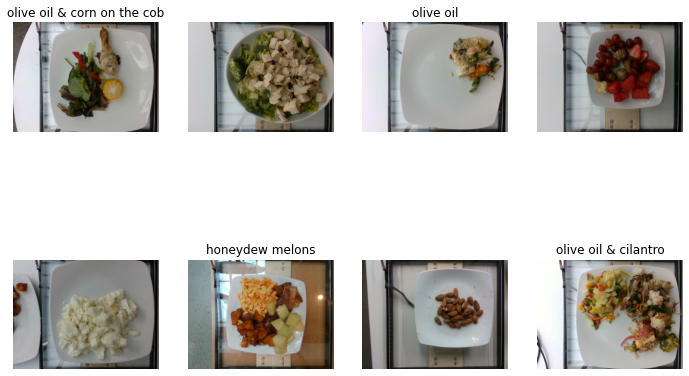

In [10]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(' & '.join(np.array(ingred)[(np.array(y_train[i])==1)]))
    plt.axis('off')

In [11]:
# define some params
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 64 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

# create datasets
train_ds = create_dataset(X_train, y_train, is_training=True,
                          img_size = IMG_SIZE, channels = CHANNELS,
                          batch_size = BATCH_SIZE, buffer_size = SHUFFLE_BUFFER_SIZE)

val_ds = create_dataset(X_val, y_val,
                        img_size = IMG_SIZE, channels = CHANNELS,
                        batch_size = BATCH_SIZE, buffer_size = SHUFFLE_BUFFER_SIZE)

In [12]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (64, 224, 224, 3)
Shape of labels array: (64, 10)


# Models

In [18]:
efficientNet =tf.keras.applications.efficientnet.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = efficientNet.output
#x = tf.keras.layers.Rescaling(1./255)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

predictions = tf.keras.layers.Dense(10, activation='sigmoid')(x)
efficientnet_model = Model(inputs=efficientNet.input, outputs=predictions)


In [19]:
SumBinaryCrossEntropy = tf.keras.losses.BinaryCrossentropy(reduction = tf.keras.losses.Reduction.SUM)
MeanBinaryCrossEntropy = tf.keras.losses.BinaryCrossentropy(reduction = tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
IndividualBinaryCrossEntropy = tf.keras.losses.BinaryCrossentropy(reduction = tf.keras.losses.Reduction.NONE, axis = None)

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]

In [20]:
EPOCHS = 10
lr = 0.0001
inputshape = 224

efficientnet_model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
loss= MeanBinaryCrossEntropy, 
metrics = ['accuracy'])

efficientnet_history= efficientnet_model.fit(train_ds, epochs=EPOCHS, callbacks = callbacks, validation_data=val_ds)

Epoch 1/10
44/44 [==============================] - 120s 3s/step - loss: 0.8288 - accuracy: 0.2548 - val_loss: 0.6524 - val_accuracy: 0.9093
Epoch 2/10
44/44 [==============================] - 113s 3s/step - loss: 0.7192 - accuracy: 0.3514 - val_loss: 0.6450 - val_accuracy: 0.9231
Epoch 3/10
44/44 [==============================] - 113s 3s/step - loss: 0.6696 - accuracy: 0.3793 - val_loss: 0.6255 - val_accuracy: 0.8797
Epoch 4/10
44/44 [==============================] - 113s 3s/step - loss: 0.6210 - accuracy: 0.3891 - val_loss: 0.5841 - val_accuracy: 0.2742
Epoch 5/10
44/44 [==============================] - 112s 3s/step - loss: 0.5781 - accuracy: 0.4058 - val_loss: 0.5551 - val_accuracy: 0.4103
Epoch 6/10
44/44 [==============================] - 115s 3s/step - loss: 0.5333 - accuracy: 0.4200 - val_loss: 0.5128 - val_accuracy: 0.7968
Epoch 7/10
44/44 [==============================] - 114s 3s/step - loss: 0.4905 - accuracy: 0.4356 - val_loss: 0.5194 - val_accuracy: 0.2643
Epoch 8/10
44

In [22]:
predicted = efficientnet_model.predict(val_ds)

8/8 [==============================] - 6s 585ms/step


In [ ]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

# Metrics

In [114]:
# get the labels 
predictions = []
labels =  []

for x, y in val_ds:
  predictions.append(efficientnet_model.predict(x).tolist())
  labels.append(y.numpy().tolist())

2/2 [==============================] - 0s 231ms/step


In [119]:
predictions2 = []
for e1 in predictions:
   for e2 in e1:
      predictions2.append(e2)

In [123]:
labels2 = []
for e1 in labels:
   for e2 in e1:
      labels2.append(e2)

In [124]:
np.array(predictions2).shape

(507, 10)

In [ ]:
predictions

In [126]:
np.array(labels2).shape

(507, 10)

In [129]:
os.chdir("./data/Nutrition5k/test_rgb")
print(len([name for name in os.listdir('.') if os.path.isfile(name)]))

507


In [220]:
# 1. precision, 2. recall, 3. accuracy, 4. AUC, 5. AUC-PR

from sklearn import metrics

def probability_to_label(prob, threshold = 0.5):
  if prob >= 0.5:
    prob = 1
  else:
    prob = 0
  return prob
  
def predict_label(predictions, threshold = 0.5):
  predicted_label = []
  for i in predictions:
    new_label = map(probability_to_label, i)
    predicted_label.append(list(new_label))
  return predicted_label


def compute_metrics(pred, lab, threshold = 0.5):
  y_pred = predict_label(pred, threshold = threshold)
  #confusion_matirx = multilabel_confusion_matrix(lab, y_pred)
  print("Precision of each label:", [round(elem,2) for elem in metrics.precision_score(lab, y_pred, average=None)])  
  print("Recall of each label:", [round(elem,2) for elem in metrics.recall_score(lab, y_pred, average=None)])
  print("F1 of each label:", [round(elem,2) for elem in metrics.f1_score(lab, y_pred, average=None)])
  accuracy = []
  for i in range(10):
    accuracy.append(round(metrics.accuracy_score(np.array(lab)[:,i], np.array(y_pred)[:,i]),2))
    #print("Accuracy of label{}: {}".format(i+1, metrics.accuracy_score(np.array(lab)[:,i], np.array(y_pred)[:,i])))
  print("Accuracy of each label", accuracy)
  auc = []
  for i in range(10):
    #try:
      #print("AUC of label{}: {} ".format(i+1, metrics.roc_auc_score(np.array(lab)[:,i], np.array(pred)[:,i],average=None)))
    auc_1 = round(metrics.roc_auc_score(np.array(lab)[:,i], np.array(pred)[:,i]),2)
    #except:
      #auc_1 = None
    auc.append(auc_1)
  print("AUC of each label", auc)
  AUC_PR = []
  for i in range(10):
    AUC_PR.append(round(metrics.average_precision_score(np.array(lab)[:,i], np.array(pred)[:,i]),2))
  print("AUC-PR of each label", AUC_PR)
  


In [154]:
len(np.unique(labels2))

2

In [ ]:
predict_label(predictions2)

In [221]:
compute_metrics(predictions2, labels2)

Precision of each label: [0.37, 0.32, 0.03, 0.03, 0.01, 0.03, 0.0, 0.0, 0.0, 0.0]
Recall of each label: [0.03, 0.17, 0.13, 0.08, 0.12, 0.75, 0.0, 0.0, 0.0, 0.0]
F1 of each label: [0.06, 0.22, 0.05, 0.04, 0.02, 0.06, 0.0, 0.0, 0.0, 0.0]
Accuracy of each label [0.55, 0.92, 0.86, 0.81, 0.49, 0.45, 0.98, 0.86, 1.0, 0.94]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


ValueError: ignored

In [233]:
print(np.array(labels2)[:, 9])
print(np.array(predict_label(predictions2))[:,9])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 